                                                file  \
0  CWE121_Stack_Based_Buffer_Overflow__CWE129_fge...   
1  CWE121_Stack_Based_Buffer_Overflow__CWE129_fge...   
2  CWE121_Stack_Based_Buffer_Overflow__CWE129_con...   
3  CWE121_Stack_Based_Buffer_Overflow__CWE129_con...   
4  CWE121_Stack_Based_Buffer_Overflow__CWE129_ran...   

                                            function          status tool  \
0  CWE121_Stack_Based_Buffer_Overflow__CWE129_fge...   true_positive  ast   
1  CWE121_Stack_Based_Buffer_Overflow__CWE129_fge...  false_positive  ast   
2  CWE121_Stack_Based_Buffer_Overflow__CWE129_con...   true_positive  ast   
3  CWE121_Stack_Based_Buffer_Overflow__CWE129_con...  false_positive  ast   
4  CWE121_Stack_Based_Buffer_Overflow__CWE129_ran...   true_positive  ast   

      cwe info  
0  CWE121  NaN  
1  CWE121  NaN  
2  CWE121  NaN  
3  CWE121  NaN  
4  CWE121  NaN  


<Figure size 1008x576 with 0 Axes>

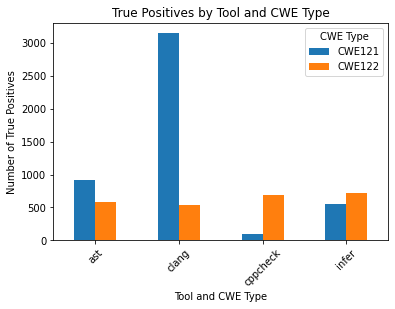

<Figure size 1008x576 with 0 Axes>

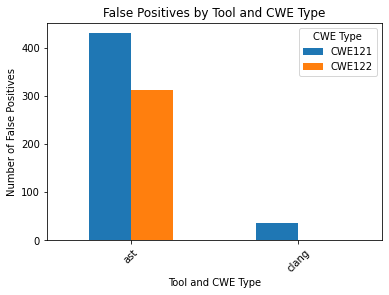

In [22]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Directory containing the results
RESULTS_PATH = os.path.join(Path.cwd().parent, 'results')

# Tools and CWE types
tools = ['ast', 'clang', 'cppcheck', 'infer']
cwe_types = ['CWE121', 'CWE122']
labels = {
    'ast': 'AST Insight',
    'infer': 'FB Infer',
    'cppcheck': 'CPP Check',
    'clang': 'Clang SA'
}

# Combine JSON data into a single DataFrame
all_data = []

for tool in tools:
    for cwe in cwe_types:
        file_path = os.path.join(RESULTS_PATH, f'{cwe}_{tool}_results.json')
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                data = json.load(file)
                for entry in data:
                    entry['tool'] = tool
                    entry['cwe'] = cwe
                    all_data.append(entry)

df = pd.DataFrame(all_data)

# Check the structure of the DataFrame
print(df.head())

# Filter for true positives and false positives
true_positives = df[df['status'] == 'true_positive']
false_positives = df[df['status'] == 'false_positive']

# Count the occurrences of each status for each tool and CWE type
tp_counts = true_positives.groupby(['tool', 'cwe']).size().unstack().fillna(0)
fp_counts = false_positives.groupby(['tool', 'cwe']).size().unstack().fillna(0)

# Plot true positives
plt.figure(figsize=(14, 8))
tp_counts.plot(kind='bar')
plt.title('True Positives by Tool and CWE Type')
plt.xlabel('Tool and CWE Type')
plt.ylabel('Number of True Positives')
plt.xticks(rotation=45)
plt.legend(title='CWE Type')
plt.show()

# Plot false positives
plt.figure(figsize=(14, 8))
fp_counts.plot(kind='bar')
plt.title('False Positives by Tool and CWE Type')
plt.xlabel('Tool and CWE Type')
plt.ylabel('Number of False Positives')
plt.xticks(rotation=45)
plt.legend(title='CWE Type')
plt.show()

In [4]:
import os
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
# Define the path to your JSON files
RESULTS_PATH = os.path.join(Path.cwd().parent, 'results')
# Function to load all JSON files from the directory
def load_json_files(infer = False):
    data = {}
    for filename in os.listdir(RESULTS_PATH):
        if filename.endswith('.json'):
            if infer and 'infer' in filename:
                with open(os.path.join(RESULTS_PATH, filename), 'r') as file:
                    data.update(json.load(file))
            elif (not infer) and (not 'infer' in filename):
                with open(os.path.join(RESULTS_PATH, filename), 'r') as file:
                    data.update(json.load(file))
                
    return data



In [5]:
ast_insight_data = load_json_files()
ast_insight_df = pd.DataFrame.from_dict(ast_insight_data).transpose()

ValueError: dictionary update sequence element #0 has length 4; 2 is required

In [ ]:
len(ast_insight_df)

In [ ]:
ast_insight_df['suggestions'] = ast_insight_df['suggestions'].apply(lambda x: x if isinstance(x, list) else [])
ast_insight_df['error'] = ast_insight_df['error'].fillna('')
ast_insight_df['suggestions_count'] = ast_insight_df['suggestions'].apply(len)

len(ast_insight_df[ast_insight_df['suggestions_count'] > 0])

In [ ]:
len(ast_insight_df[ast_insight_df['status'] != 200])

In [ ]:
print('TODO: fix unary operator cases')
len(ast_insight_df[ast_insight_df['error'].str.contains('Unary')])

In [ ]:
infer_data = load_json_files(True)
infer_output_data = {}
infer_output_data = {filename: infer_data[filename]['output'] for filename in infer_data}
infer_df = pd.DataFrame.from_dict(infer_data).transpose()

In [ ]:
def count_infer_buffer_overflows_detected(output_list):
    return sum(1 for output in output_list if 'BUFFER_OVERRUN' in output['bug_type'])

In [ ]:
infer_df['output'] = infer_df['output'].apply(lambda x: x if isinstance(x, list) else [])
infer_df['error'] = infer_df['error'].fillna('')
infer_df['overflows_detected'] = infer_df['output'].apply(count_infer_buffer_overflows_detected)

In [ ]:
infer_df[infer_df['overflows_detected'] == 0]

In [ ]:
len(infer_df[infer_df['overflows_detected'] > 0])

In [ ]:
ast_detected = (ast_insight_df['suggestions_count'] > 0).sum()
infer_detected = (infer_df['overflows_detected'] > 0).sum()
total_files_ast = len(ast_insight_df)
total_files_infer = len(infer_df)

ast_labels = ['Detected', '']
ast_sizes = [ast_detected, total_files_ast - ast_detected]

infer_labels = ['Detected', '']
infer_sizes = [infer_detected, total_files_infer - infer_detected]

plt.figure(dpi=2000) 

# Create pie charts
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Pie chart for AST Insight
axs[0].pie(ast_sizes, labels=ast_labels, autopct='%1.1f%%', colors=['green', 'gray'])
axs[0].set_title('BOF Vulnerabilities Detected by AST Insight')

# Pie chart for Infer
axs[1].pie(infer_sizes, labels=infer_labels, autopct='%1.1f%%', colors=['orange', 'gray'])
axs[1].set_title('BOF Vulnerabilities Detected by Infer')
plt.savefig('detection_rate.png')
# Display the charts
plt.tight_layout()
plt.show()
